In [ ]:
!pip install pyro-ppl
!pip install umap-learn

In [4]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
import torch
import time
import torch
import torch.nn as nn
import torch.optim as optim
import umap
import time



In [5]:
# Set the number of time steps
n_steps = 100
# Set the number of random walks
n_walks = 100
batch = 100
iter = int(n_walks/batch)

# To avoid scaling issues, im going to simplify the multivariate random number generation and split the process into i independent iterations
# Generate random walks with the same mean and variance
np.random.seed(123)
cov_matrix = np.diag(np.zeros(n_walks) + 1)
cov_matrix[cov_matrix==0] = 0.1
random_walks = np.random.multivariate_normal(np.zeros(n_walks), cov_matrix, size=n_steps)
random_walks = np.cumsum(random_walks, axis=0)







In [6]:
random_walks

array([[-1.06341115,  1.09799179,  1.48004319, ...,  2.12851388,
         0.57699333,  1.8551869 ],
       [ 1.17722528,  1.148769  ,  1.48590311, ...,  2.37341841,
         1.00629187,  1.51580456],
       [ 1.59472912,  0.05842108,  1.61883421, ...,  2.97901556,
         1.19856446,  1.68113847],
       ...,
       [ 6.87403081,  1.33793898,  7.2306358 , ..., -9.11387621,
         1.19316761, 11.82228955],
       [ 8.16314717,  3.01917629,  6.75867225, ..., -8.22123624,
        -0.36757371, 13.69803028],
       [ 9.53284238,  4.45071893,  8.35569641, ..., -6.88691328,
         0.34258116, 13.74595113]])

In [7]:
#random_walks = np.concatenate(walks, axis=1)
random_walks.shape

(100, 100)

In [8]:
intercepts = np.random.normal(0, 5, n_walks)
random_walks += np.tile(intercepts, (n_steps, 1))



In [9]:
random_walks.shape

(100, 100)

In [10]:
y = np.reshape(random_walks, random_walks.shape[0]*random_walks.shape[1])

In [11]:
# Create a data frame in wide format
wide_df = pd.DataFrame(random_walks, columns=[f'x{i}' for i in range(1, n_walks+1)])

In [12]:
wide_df['t'] = range(1, n_steps + 1)

In [13]:

# Convert the wide-format DataFrame to long format
long_df = wide_df.melt(id_vars='t', var_name='level', value_name='value')


In [14]:
n_knots = 10

# Generate equally spaced knots
knots = np.linspace(min(long_df['t']), max(long_df['t']), num=n_knots)

# Define the piecewise linear function
def piecewise_linear(x, k):
    y = x - k
    y[x < 0] = 0
    y[x < k] = 0
    return y

# Define a function to create a linear spline basis
def create_basis(x, k):
    num_x = len(x)
    num_k = len(k)
    b = np.zeros((num_x, num_k))
    for i in range(num_k):
        b_i = piecewise_linear(x, k[i])
        b[:, i] = b_i
    return pd.DataFrame(b, columns=[f'basis_X{i+1}' for i in range(num_k)])



In [15]:
# Example usage
x = np.arange(1, n_steps + 1)  # Sample x values
k_values = np.arange(0, n_knots) * (n_steps / n_knots)  # Values of k
basis_matrix_wide = create_basis(x, k_values)

# Normalize the basis matrix
basis_matrix_wide.columns = [f'basis_X{i+1}' for i in range(n_knots)]


In [16]:
t = np.arange(1, n_steps + 1)
basis_matrix_wide.insert(0, 't', t)
basis_matrix_wide = pd.DataFrame(basis_matrix_wide)

# Merge the dataframes
long_df = long_df.merge(basis_matrix_wide, on='t', how='left')

In [17]:
#long_df = long_df[long_df['level'] == 'x1']

In [18]:
# Identify rows to drop
drop = long_df[long_df['level'] == 'x10'].index
indices_to_remove = [905,907,961, 991]

# Remove specified rows
filtered_indices = [i for i in drop if i not in indices_to_remove]

sample_df = long_df.drop(filtered_indices)



In [19]:
basis_vars = sample_df.columns.values[3:]

In [20]:
target = sample_df['value']

In [21]:
sample_df

,t,level,value,basis_X1,basis_X2,basis_X3,basis_X4,basis_X5,basis_X6,basis_X7,basis_X8,basis_X9,basis_X10
0,1,x1,-7.268260,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,x1,-5.027623,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,x1,-4.610119,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,x1,-4.285847,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,x1,-6.028087,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,96,x100,9.719180,96.0,86.0,76.0,66.0,56.0,46.0,36.0,26.0,16.0,6.0
9996,97,x100,9.374131,97.0,87.0,77.0,67.0,57.0,47.0,37.0,27.0,17.0,7.0
9997,98,x100,9.192035,98.0,88.0,78.0,68.0,58.0,48.0,38.0,28.0,18.0,8.0
9998,99,x100,11.067776,99.0,89.0,79.0,69.0,59.0,49.0,39.0,29.0,19.0,9.0


###Pytorch Formulation

Try and use an embedding layer instead of dummy variables

In [22]:
class EmbeddingTrendNetwork(nn.Module):
    def __init__(self, n_level, n_basis, embedding_size):
        super().__init__()

        self.n_basis = n_basis
        self.n_level = n_level

        # Fixed effect parameters
        self.F = nn.Parameter(torch.rand(n_basis))

        # Intercept random effect
        self.R_int = nn.Parameter(torch.rand(embedding_size, 1))

        # Basis slope random effects
        self.R_effect = nn.Parameter(torch.rand(embedding_size, n_basis))

        # Embedding layers
        self.L_embedding = nn.Embedding(n_level+1, embedding_size)
        self.intercept_embedding = nn.Embedding(n_level+1, embedding_size)

        # Additional parameter layers
        self.sd1 = nn.Parameter(torch.tensor(1.0)) # Error sd


    def forward(self, X, L_int):

        # Fixed effects
        xf = torch.matmul(X, self.F)


        # Apply the embedding
        E = self.L_embedding(L_int)
        L_intercept = self.intercept_embedding(L_int)

        intercept = torch.matmul(L_intercept, self.R_int)

        # Random effect slopes
        lr_slope = torch.matmul(E, self.R_effect)
        X = X[:,:,None]
        lr_slope = lr_slope[:, None, :]
        lrx = torch.matmul(lr_slope, X)

        # Sum them all together
        y_p = lrx.squeeze(1).squeeze(1) + intercept.squeeze(1) + xf

        decomp = {"Intercept":intercept,  "Random":lrx.squeeze(1).squeeze(1), "Fixed":xf}

        return y_p, E, lr_slope, decomp

    def loss(self, y_p, y):

        # Get the log likelihood for the error
        l1_dist = dist.Normal(0, torch.exp(self.sd1))
        l1 = l1_dist.log_prob(y - y_p).mean()

        # Sum them together and then scale them via the mean
        l = l1

        return -l

In [25]:
# Create an instance of the network
model = EmbeddingTrendNetwork(n_level=99, n_basis=10, embedding_size=8)



In [26]:
y = torch.tensor(np.array(sample_df['value']))
y = y/torch.max(y)
y = y

In [27]:
# Example data
# Create a matrix containing all basis functions as columns
pred_df = sample_df[basis_vars]
X = torch.tensor(np.array(pred_df.iloc[:,0:pred_df.shape[0]]).astype('float32'))
X = X/100

In [28]:
level = pd.get_dummies(sample_df['level'])
cols = [f"x{int(i)}" for i in range(1,n_walks)]
level = level[cols]

L = torch.tensor(np.array(level).astype('float32'))

In [29]:
L_int = torch.tensor((pd.Categorical(sample_df['level'])).codes, dtype=torch.int)
L_int = L_int

In [30]:
# Define the optimizer (SGD)
optimizer = optim.RMSprop(model.parameters(), lr=1e-1)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)

num_epochs = 10000
num_obs = X.shape[0]

history = []
for epoch in range(num_epochs):
    optimizer.zero_grad()

    if epoch == (num_epochs - 1):
      s = torch.tensor(np.arange(X.shape[0]))
    else:
      # Shuffle the observation order before each training round, unless its the last round
      s= torch.randperm(num_obs)

    y_p, E, lr_slope, decomp = model(X[s,:], L_int[s])
    loss = model.loss(y_p, y[s])
    history.append(loss.detach().numpy())
    loss.backward()
    optimizer.step()
    scheduler.step()
    if epoch % 100 == 0:
      print(f"LR:{optimizer.param_groups[0]['lr']}")
      print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss}')


LR:0.0999
Epoch [1/10000], Loss: 3.2414613272857182
LR:0.09038873549665954
Epoch [101/10000], Loss: 0.931962250006343
LR:0.08178301806491572
Epoch [201/10000], Loss: 0.8491150722353181
LR:0.07399663251239438
Epoch [301/10000], Loss: 0.009733650998127178
LR:0.0669515720100734
Epoch [401/10000], Loss: -0.13154415386025184
LR:0.060577256591632454
Epoch [501/10000], Loss: -0.4079486348646092
LR:0.05480982605780123
Epoch [601/10000], Loss: -0.646366072893399
LR:0.049591500201766864
Epoch [701/10000], Loss: -0.43514992165444083
LR:0.04486999994614655
Epoch [801/10000], Loss: -0.5364266524717652
LR:0.04059802359226594
Epoch [901/10000], Loss: 4.289758311100552
LR:0.03673277293461932
Epoch [1001/10000], Loss: -1.113814795243932
LR:0.03323552449295458
Epoch [1101/10000], Loss: -0.1934417554302686
LR:0.030071241566430654
Epoch [1201/10000], Loss: -1.1506058130782835
LR:0.027208223223265812
Epoch [1301/10000], Loss: -1.2562576943866168
LR:0.02461778670932776
Epoch [1401/10000], Loss: -1.319823205

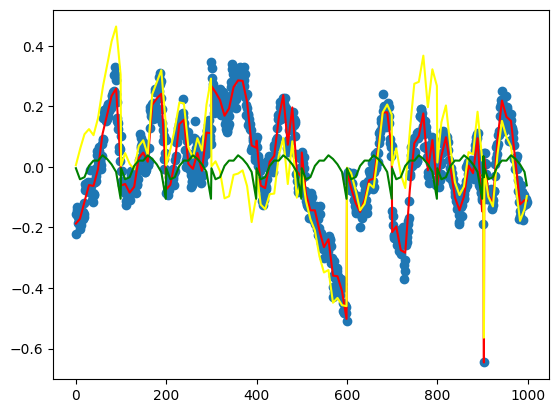

In [31]:
plt.plot(range(0,999), y_p.detach().numpy()[0:999], color="red")
plt.plot(decomp['Random'].detach().numpy()[0:999], color="yellow")
plt.plot(decomp['Fixed'].detach().numpy()[0:999], color="green")
plt.scatter(range(0,999),y[0:999])
plt.show()

In [32]:
y_test = torch.tensor(np.array(long_df['value']))
y_test = y_test/torch.max(y_test) # Technically, the scaling should be based on y. Small data leak but im lazy.
y_test = y_test

level = pd.get_dummies(long_df['level'])

cols = [f"x{int(i)}" for i in range(1,100)]
level = level[cols]
L = torch.tensor(np.array(level).astype('float32'))
L = L

# Example data
# Create a matrix containing all basis functions as columns
pred_df = long_df[basis_vars]
X = torch.tensor(np.array(pred_df.iloc[:,:pred_df.shape[0]]).astype('float32'))
X = X/100
X = X

L_int = torch.tensor((pd.Categorical(long_df['level'])).codes, dtype=torch.int)
L_int = L_int

In [33]:
y_reconstruct = model(X,L_int)

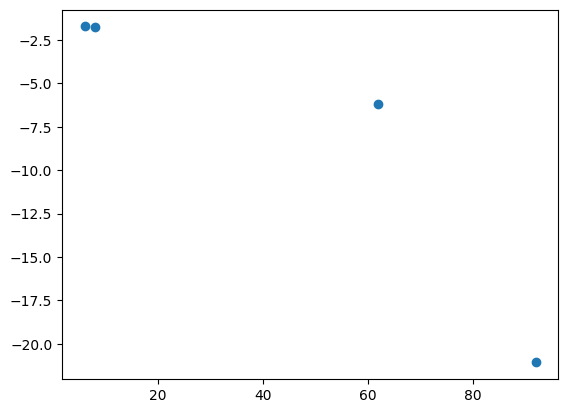

In [43]:
plt.scatter(sample_df[sample_df['level'] == 'x10']['t'], sample_df[sample_df['level'] == 'x10']['value'])

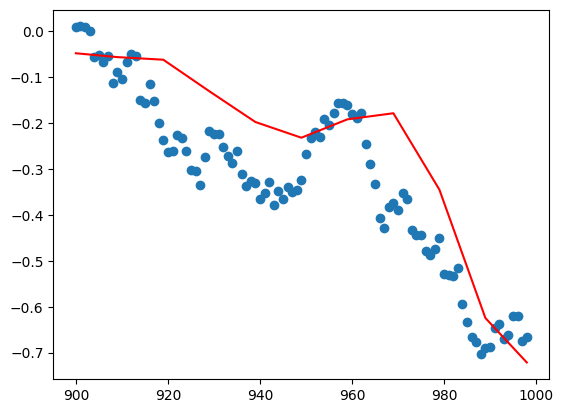

In [32]:
plt.plot(range(900,999), y_reconstruct[0].detach().numpy()[900:999], color="red")
plt.scatter(range(900,999),y_test[900:999])
plt.show()